Xác định tình trạng bánh xe 

#1.Import dữ liệu

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
#link dataset: https://drive.google.com/drive/folders/1_pW_PkMJjuNwxwGTzHv3IFW-EYSYwHOb?usp=sharing

#2.Import thư viện

In [6]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout,Add
from tensorflow.keras import backend as K
import keras
from keras.models import Sequential, Model
from keras.models import load_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import MaxPool2D
from google.colab.patches import cv2_imshow
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import skimage.io
import tensorflow 
import tqdm
import glob

from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import backend, models, layers, Sequential
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Add
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2

from tqdm import tqdm
import random as rn
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

from skimage import feature, color, data
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV

#3.Nạp dữ liệu đã dán nhãn

In [7]:
train_path="/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/train"#khai báo thu mục chứa đựng tập train 
val_path="/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/val"#khai báo thu mục chứa đựng tập val
test_path="/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/test"#khai báo thu mục chứa đựng tập test
class_names=os.listdir(train_path) #cho biết các class(nhãn) tập train là tên các thư mục con class_name=[full,flat,worn,none]
class_names_test=os.listdir(test_path)#tương tự cho tập test

In [8]:
print(class_names)

['flat', 'full', 'notire']


In [9]:
print(class_names_test)

['flat', 'full', 'notire']


#4.Khám phá dữ liệu

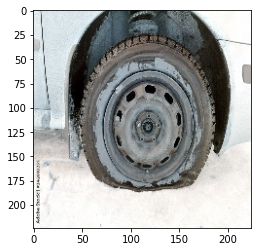

In [10]:
# Ví dụ về đọc 1 ảnh trong tập
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
image=cv2.imread("/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/test/flat/flat(316).jpg")
plt.imshow(image)

##4.1 bộ dữ liệu train

In [11]:
#so luong anh trong full (240 hình ảnh)
len(os.listdir("/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/train/full"))

280

In [12]:
#so luong anh trong flat (240 hình ảnh)
len(os.listdir("/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/train/flat"))

280

In [13]:
#so luong anh trong worn(240 hình ảnh)
len(os.listdir("/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/train/notire"))

280

##4.1 Bộ dữ liệu val 

In [14]:
#so luong anh trong full 
len(os.listdir("/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/val/full"))

80

In [15]:
len(os.listdir("/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/val/flat"))

80

In [16]:
len(os.listdir("/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/val/notire"))

80

##4.3 Bộ dữ liệu test

In [17]:
#so luong anh trong full
len(os.listdir("/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/test/full"))

40

In [18]:
#so luong anh trong flat 
len(os.listdir("/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/test/flat"))

40

In [19]:
#so luong anh trong no-tire 
len(os.listdir("/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/test/notire"))

40

#5.Mô hình máy học truyền thống

##5.1.Tiền xử lý dữ liệu


In [20]:
train_img_path = "/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/train"

test_img_path = "/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/test"

val_img_path = "/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/val"
X_train =[] 
label_train = [] 

X_test = [] 
label_test = [] 

X_val =[] 
label_val = [] 


label=os.listdir(train_img_path)

###Trích xuất Hog

####Hàm trích xuất Hog

In [21]:
def jpeg_to_array (label, img_root_path,data_type):
    label_path = os.path.join(img_root_path,label.lower())
    print('Loading ' + data_type +' images for label: '+label)
    for img in os.listdir(label_path):
        img_path = os.path.join(label_path,img)##địa chỉ hình
        if img_path.endswith('.jpg'):
            if(data_type == 'Training'):
                img=Image.open(img_path)
                X_train.append(np.array(feature.hog(img)))
                label_train.append(str(label))
            if(data_type =='test'):
                img=Image.open(img_path)
                X_test.append(np.array(feature.hog(img))) 
                label_test.append(np.array(str(label)))
            if(data_type =='val'):
              img=Image.open(img_path)
              X_val.append(np.array(feature.hog(img)))
              label_val.append(np.array(str(label)))    

###Tạo tập dữ liệu

In [22]:
[jpeg_to_array(scene,train_img_path,'Training')for scene in label]
len(X_train)

Loading Training images for label: flat
Loading Training images for label: full
Loading Training images for label: notire


840

In [23]:
[jpeg_to_array(scene,test_img_path,'test')for scene in label]
len(X_test)

Loading test images for label: flat
Loading test images for label: full
Loading test images for label: notire


120

In [24]:
[jpeg_to_array(scene,val_img_path,'val')for scene in label]
len(X_val)

Loading val images for label: flat
Loading val images for label: full
Loading val images for label: notire


240

####Encode nhãn từ (flat, full, notire) thành (0, 1, 2)

In [25]:
le = LabelEncoder()
y_train =le.fit_transform(label_train)
y_test=le.fit_transform(label_test)
y_val=le.fit_transform(label_val)

##5.2.SVM

###Tạo model Linear SVC  và huấn luyện

In [26]:
lsvc = LinearSVC(C=0.8,random_state=0,loss='squared_hinge',tol=0.001,verbose=1,dual=False,max_iter=7600)

In [27]:
lsvc.fit(X_train,y_train)

[LibLinear]

LinearSVC(C=0.8, dual=False, max_iter=7600, random_state=0, tol=0.001,
          verbose=1)

###Model Tuner


Tìm C tốt nhất

In [28]:
param_grid = {'C': [0.8,0.9, 1,1.1,1.2,1.3,1.4]}

In [ ]:
grid = GridSearchCV(lsvc,param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)
print(grid.best_estimator_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[LibLinear][CV] END ..............................................C=0.8; total time=  23.2s
[LibLinear][CV] END ..............................................C=0.8; total time=  21.6s
[LibLinear][CV] END ..............................................C=0.8; total time=  21.3s
[LibLinear][CV] END ..............................................C=0.8; total time=  20.8s
[LibLinear][CV] END ..............................................C=0.8; total time=  20.4s
[LibLinear][CV] END ..............................................C=0.9; total time=  23.0s
[LibLinear][CV] END ..............................................C=0.9; total time=  19.4s
[LibLinear][CV] END ..............................................C=0.9; total time=  16.8s
[LibLinear][CV] END ..............................................C=0.9; total time=  20.1s
[LibLinear][CV] END ..............................................C=0.9; total time=  19.7s
[LibLinear][CV] END 

--->C=1 là tốt nhất( tức C mặc định)

In [ ]:
lsvc_best  =grid.best_estimator_

In [ ]:
lsvc_best.fit(X_train,y_train)

[LibLinear]

LinearSVC(C=1, dual=False, max_iter=7600, random_state=0, tol=0.001, verbose=1)

Save model

In [ ]:
import pickle
filename = 'lsvc_best.sav'
pickle.dump(lsvc_best, open(filename, 'wb'))

###Đánh giá

In [ ]:
cv_scores = cross_val_score(lsvc, X_train, y_train, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]CV average score: 0.70


In [ ]:
cv_scores = cross_val_score(lsvc_best, X_train, y_train, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]CV average score: 0.70


In [ ]:
ypred = lsvc.predict(X_test)
ypred_best=lsvc.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, ypred)
#cm = confusion_matrix(y_test, ypred_best)

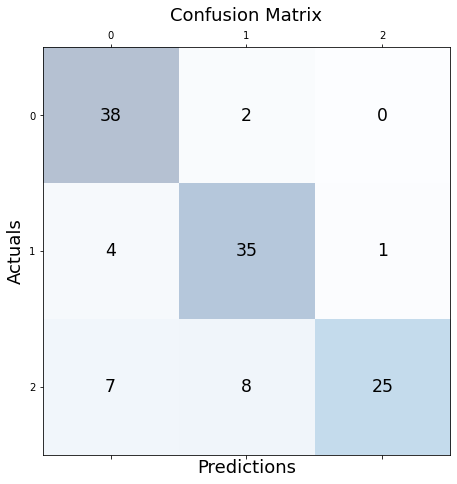

              precision    recall  f1-score   support

           0       0.78      0.95      0.85        40
           1       0.78      0.88      0.82        40
           2       0.96      0.62      0.76        40

    accuracy                           0.82       120
   macro avg       0.84      0.82      0.81       120
weighted avg       0.84      0.82      0.81       120

              precision    recall  f1-score   support

           0       0.78      0.95      0.85        40
           1       0.78      0.88      0.82        40
           2       0.96      0.62      0.76        40

    accuracy                           0.82       120
   macro avg       0.84      0.82      0.81       120
weighted avg       0.84      0.82      0.81       120



In [ ]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
cr = classification_report(y_test, ypred)
print(cr)
cr = classification_report(y_test, ypred)
print(cr)

##5.3.KNN

###Tạo model KNN

In [ ]:
from sklearn import neighbors

In [ ]:
knn = neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

###Model Tuner

Tìm K tốt nhất

In [ ]:
error_rate = []
for i in range(1,50):
    knn = neighbors.KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_val)
    error_rate.append(np.mean(pred != y_val))

([<matplotlib.axis.XTick at 0x7f228b370990>,
 <a list of 11 Text major ticklabel objects>)

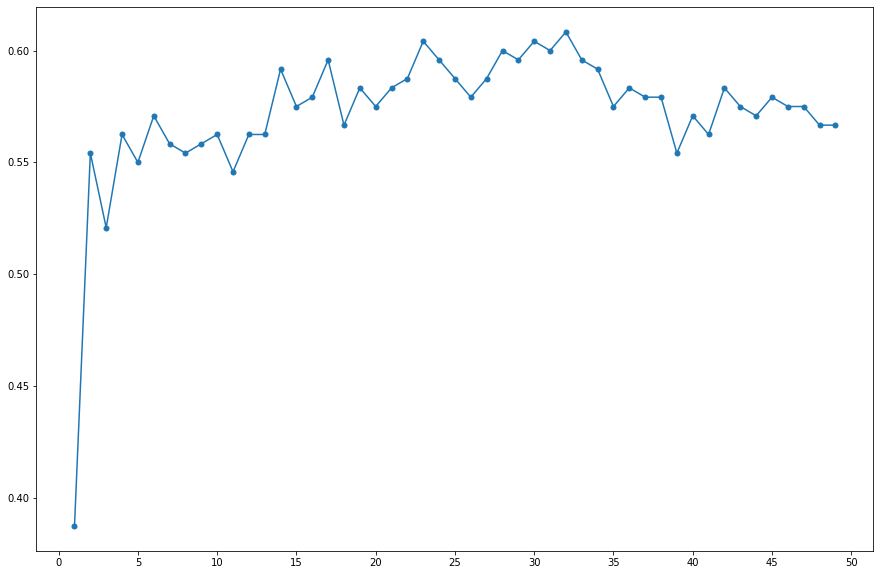

In [ ]:
x = np.random.randint(low=0, high=50, size=50)
plt.figure(figsize=(15,10))
plt.plot(range(1,50),error_rate, marker='o', markersize=5)
plt.xticks(np.arange(0, len(x)+1, 5))

--->Best K=**22:**

In [ ]:
knn = neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
knn_best = neighbors.KNeighborsClassifier(n_neighbors = 22)
knn_best.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=22)

Save model

In [ ]:
import pickle
filename = 'knn_best.sav'
pickle.dump(knn_best, open(filename, 'wb'))

###Đánh giá

In [ ]:
cv_scores = cross_val_score(knn, X_train, y_train, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.41


In [ ]:
cv_scores = cross_val_score(knn_best, X_train, y_train, cv=10)
print("CV average score: %.2f" % cv_scores.mean())

CV average score: 0.39


In [ ]:
ypred = knn.predict(X_test)
ypred_best = knn_best.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, ypred)
#cm = confusion_matrix(y_test, ypred_best)

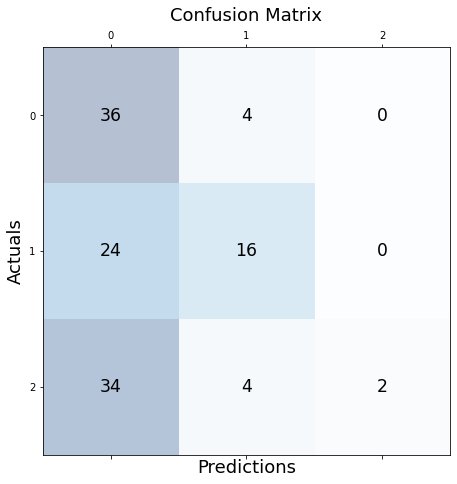

              precision    recall  f1-score   support

           0       0.38      0.90      0.54        40
           1       0.67      0.40      0.50        40
           2       1.00      0.05      0.10        40

    accuracy                           0.45       120
   macro avg       0.68      0.45      0.38       120
weighted avg       0.68      0.45      0.38       120



In [ ]:
cm = confusion_matrix(y_test, ypred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
cr = classification_report(y_test, ypred)
print(cr)

#6.Deep Learning (VGG16)

##6.1.Tiền xử lý dữ liệu

In [ ]:
train_datagen = ImageDataGenerator(rescale            = 1./255, # sử dụng rescale 1./255 để đưa dữ liệu rgb pixel từ dạng (0,255) thành (0,1) 
                                  rotation_range     = 5, 
                                  zoom_range         = 0.10,
                                  width_shift_range  =0.05,
                                  height_shift_range =0.05) #sử dụng imagedatagenerator để tăng bộ dữ liệu train lên bằng các image augment 
test_datagen = ImageDataGenerator(rescale            = 1./255) # bộ test sẽ chỉ sử dụng rescale không có augment để tăng tính xác thực mô hình

In [ ]:
train_gen = train_datagen.flow_from_directory("/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/train",target_size=(224, 224),batch_size=16,shuffle=True,class_mode='categorical')
val_gen = test_datagen.flow_from_directory("/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/val",target_size=(224,224),batch_size=16,shuffle=False,class_mode='categorical')
test_gen = test_datagen.flow_from_directory("/content/gdrive/MyDrive/DS102/tire-dataset/Dataset/test",target_size=(224,224),batch_size=16,shuffle=False,class_mode='categorical')

Found 840 images belonging to 3 classes.
Found 240 images belonging to 3 classes.
Found 120 images belonging to 3 classes.


In [ ]:
print(val_gen.class_indices)

{'flat': 0, 'full': 1, 'notire': 2}


##6.2.Xây dựng model(sử dụng model có sẵn vgg16 có tinh chỉnh layer cuối thành sofmax 3 biến)

In [ ]:
def VGG16():
    model = Sequential()
    model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='vgg16'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dense(128, activation='relu', name='fc2'))
#sigmud 
    model.add(Dense(3, activation='softmax', name='output'))
    return model

In [ ]:
model=VGG16()

In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.layers.convolutional.Conv2D object at 0x7f228b248a90> True
<keras.layers.convolutional.Conv2D object at 0x7f228c796e10> True
<keras.layers.pooling.MaxPooling2D object at 0x7f228a141e10> True
<keras.layers.convolutional.Conv2D object at 0x7f228a12ded0> True
<keras.layers.convolutional.Conv2D object at 0x7f228a1349d0> True
<keras.layers.pooling.MaxPooling2D object at 0x7f228b25f890> True
<keras.layers.convolutional.Conv2D object at 0x7f228a139e50> True
<keras.layers.convolutional.Conv2D object at 0x7f228a0c4c10> True
<keras.layers.convolutional.Conv2D object at 0x7f228a0c4590> True
<keras.layers.pooling.MaxPooling2D object at 0x7f228a174690> True
<keras.layers.convolutional.Conv2D object at 0x7f228a139bd0> True
<keras.layers.convolutional.Conv2D object at 0x7f228a174110> True
<keras.layers.convolutional.Conv2D object at 0x7f228a0ce650> True
<keras.layers.pooling.MaxPooling2D object at 0x7f228a0bc2d0> True
<keras.layers.convolutional.Conv2D object at 0x7f228a0d2290> True
<keras.lay

In [ ]:
Vgg16 = Model(inputs=model.input, outputs=model.get_layer('vgg16').output)

Load trọng số có sẵn 


In [ ]:
Vgg16.load_weights("/content/gdrive/MyDrive/DS102/tire-dataset/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5") 
#Link kenel:shorturl.at/jsPTY

In [ ]:
for layer in Vgg16.layers:
    layer.trainable = False #phải freeze các layer để không thay đổi weight(trọng số) trong quá trình train 

In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.layers.convolutional.Conv2D object at 0x7f228b248a90> False
<keras.layers.convolutional.Conv2D object at 0x7f228c796e10> False
<keras.layers.pooling.MaxPooling2D object at 0x7f228a141e10> False
<keras.layers.convolutional.Conv2D object at 0x7f228a12ded0> False
<keras.layers.convolutional.Conv2D object at 0x7f228a1349d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f228b25f890> False
<keras.layers.convolutional.Conv2D object at 0x7f228a139e50> False
<keras.layers.convolutional.Conv2D object at 0x7f228a0c4c10> False
<keras.layers.convolutional.Conv2D object at 0x7f228a0c4590> False
<keras.layers.pooling.MaxPooling2D object at 0x7f228a174690> False
<keras.layers.convolutional.Conv2D object at 0x7f228a139bd0> False
<keras.layers.convolutional.Conv2D object at 0x7f228a174110> False
<keras.layers.convolutional.Conv2D object at 0x7f228a0ce650> False
<keras.layers.pooling.MaxPooling2D object at 0x7f228a0bc2d0> False
<keras.layers.convolutional.Conv2D object at 0x7f228a0d2290> F

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

##6.3.Model tunner

In [ ]:
from tensorflow.keras.optimizers import Adam 
opt = Adam(lr=0.01)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5) #Tìm ra model có val_accuracy lớn nhất và trong 5 chu kì val_accuracy không tăng thì dừng
mc = ModelCheckpoint('/content/gdrive/My Drive/best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True) 

##6.4.Chạy Model 

In [ ]:
H = model.fit(train_gen,validation_data=val_gen,epochs=100,verbose=1,callbacks=[mc,es])

Epoch 1/100
53/53 [==============================] - 490s 9s/step - loss: 10.7642 - accuracy: 0.5476 - val_loss: 1.7595 - val_accuracy: 0.5458
Epoch 2/100
53/53 [==============================] - 485s 9s/step - loss: 0.4512 - accuracy: 0.8060 - val_loss: 0.3095 - val_accuracy: 0.8625
Epoch 3/100
53/53 [==============================] - 483s 9s/step - loss: 0.4471 - accuracy: 0.8381 - val_loss: 0.7874 - val_accuracy: 0.7292
Epoch 4/100
41/53 [======================>.......] - ETA: 1:24 - loss: 0.2771 - accuracy: 0.9012

In [ ]:
#model.save('my_model.h5')

##6.5.Đánh giá

load model

In [ ]:
model = keras.models.load_model('/content/gdrive/My Drive/best_model.h5')

In [ ]:
import matplotlib.pyplot as plt

get_acc = H.history['accuracy']
value_acc = H.history['val_accuracy']
get_loss = H.history['loss']
validation_loss = H.history['val_loss']

epochs = range(len(get_acc))
plt.plot(epochs, get_acc, 'r', label='Accuracy of Training data')
plt.plot(epochs, value_acc, 'b', label='Accuracy of Validation data')
plt.title('Training vs validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
epochs = range(len(get_loss))
plt.plot(epochs, get_loss, 'r', label='Loss of Training data')
plt.plot(epochs, validation_loss, 'b', label='Loss of Validation data')
plt.title('Training vs validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)           
            errors=errors + 1
        y_pred.append(pred_index)    
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code           
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):                
                split1=os.path.split(error_list[i])                
                split2=os.path.split(split1[0])                
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])               
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
sns.set_style('darkgrid')
print_code=0
test_steps=120//8 #number of image// batchsize
working_dir=r'./'
preds=model.predict(test_gen, steps=test_steps, verbose=1) 
print_info( test_gen, preds, print_code, working_dir, "expression" ) 